## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. 

In [2]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'].str.contains('>50K')])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'].str.contains('<=50K')])

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

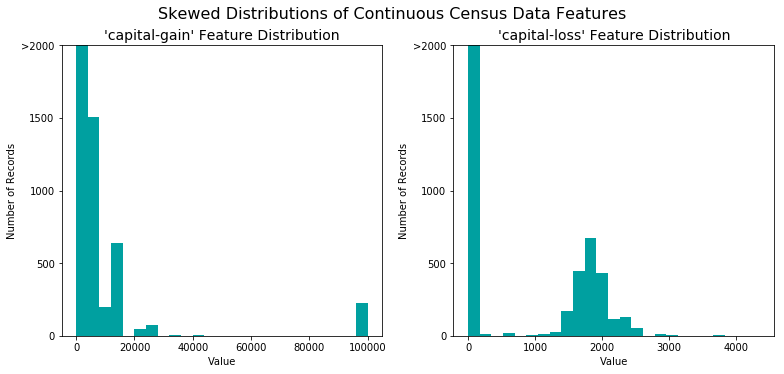

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.


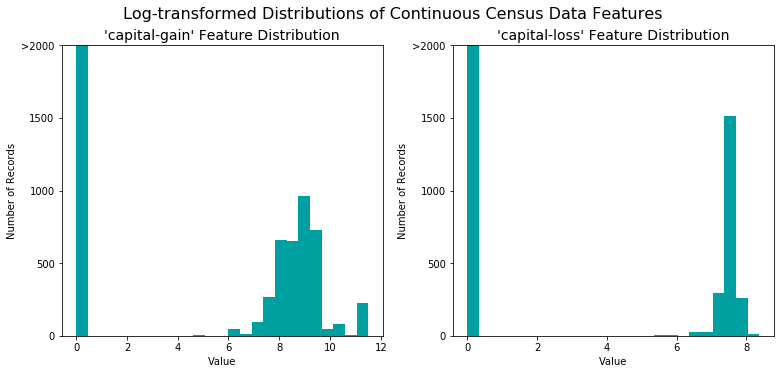

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

In [8]:
TP = np.sum(income)
FP = income.count() - TP
TN = 0 
FN = 0

# Calculate accuracy, precision and recall
accuracy = (TP+TN)/n_records
recall = TP/(TP+FN)
precision = TP/(TP+FP)
Beta = 0.5 ** 2

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore =(1+Beta)*((precision*recall)/((Beta*precision)+recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**1- Logistic Regression model**

Describe one real-world application in industry where the model can be applied.
*  It can be used in medicine to predict if a patient has pneumonia or not.

What are the strengths of the model; when does it perform well?
*  It can work on both linear and non-linear relationship between the input and output variables. Also, we can avoid overfitting when using this algorithm.

What are the weaknesses of the model; when does it perform poorly?
* This algorithm cannot perform well in complex situations. Also, if the function has too many non-linear relationships, the performance of the algorithm will decrease.

What makes this model a good candidate for the problem, given what you know about the data?

* Logistic regression is a binary classification algorithm which makes it a good candidate for the problem, since we are interested in finding individuals making more than $50,000.

*Citation* 
https://www.techiexpert.com/modern-machine-learning-algorithms-strengths-and-weaknesses/


**2- Decision tree model**

Describe one real-world application in industry where the model can be applied.
* It is used to classify the weather in a morning to decide if it is suitable to play football or not. 

What are the strengths of the model; when does it perform well?
* Decision trees can generate understandable rules in addition to their ability to handle both continuous and categorical variables. Also, decision trees can help us infer the most important features in the classification.

What are the weaknesses of the model; when does it perform poorly?
* If the classification problem has many classes and relatively small number of training examples, decision trees will be error prone. Also, decision trees training can be computationally expensive. It performs poorly when handling continues attributes, or then there are missing values in training data.

What makes this model a good candidate for the problem, given what you know about the data?
* Since decision trees can be used in classification, it is a good candidate for the problem, as we are interested in finding individuals making more than $50,000.

*Citation*
https://medium.com/@pralhad2481/chapter-3-decision-tree-learning-part-2-issues-in-decision-tree-learning-babdfdf15ec3

https://www.geeksforgeeks.org/decision-tree/


**3- Random Forest model**

Describe one real-world application in industry where the model can be applied.
* Random forests can be used in suggesting products for a customer in e-commerce sector.

What are the strengths of the model; when does it perform well?
* Runtimes of random forest are fast, and they are capable of handling unbalanced and missing data.

What are the weaknesses of the model; when does it perform poorly?
* They cannot predict beyond the range in the training data. If the dataset is noisy, they may over-fit the data.

What makes this model a good candidate for the problem, given what you know about the data?
* Since random forests are an efficient implementation of decision trees described above. It seems that they are a good candidate for the problem.

*Citation* https://www.newgenapps.com/blog/random-forest-analysis-in-ml-and-when-to-use-it/

https://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 

    results = {}
    
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end-start
        
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
   
    results['pred_time'] = end-start
            
    results['acc_train'] =  accuracy_score(y_train[:300], predictions_train)
        
    results['acc_test'] =  accuracy_score(y_test, predictions_test)
    
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Implementation: Initial Model Evaluation


DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


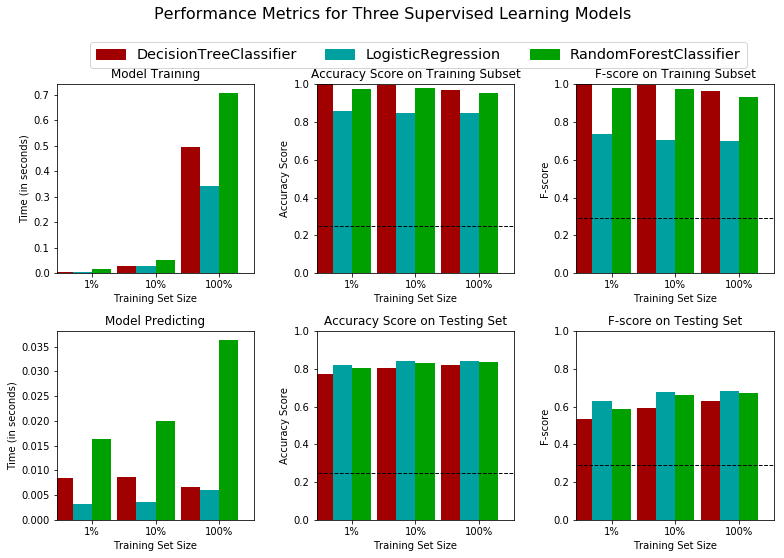

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = LogisticRegression(random_state=0)
clf_C = RandomForestClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = int(len(y_train))
samples_10 = int(len(y_train)*0.10)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

**Answer: It is clear that Logistic regression is the best model for the task of identifying individuals that make more than $50,000 since it has the highest F-score when 100% of the training set is used. In addition, it is considered fast in both training and testing tasks compared to the other algorithms. Since we want to classify the individuals into to groups, it is clear that logistic regression is suitable for this task.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**Answer: Let’s say that there is a student who applied to study at a particular university, and you have some information about the student such as her grades in high school, her admission test result, and her address. Based on data provided earlier, LR will do some mathematical calculations to learn from the dataset, then predict the probability that this student gets admitted at the university.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. 

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Initialize the classifier
clf = LogisticRegression(random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = parameters ={'C':[0.001,0.01,0.1,1,10,100],'penalty':['l2'],'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8423
Final F-score on the testing data: 0.6849


### Question 5 - Final Model Evaluation

What is your optimized model's accuracy and F-score on the testing data?

* Accuracy is 0.8423 , and F-score is 0.6849.

Are these scores better or worse than the unoptimized model?

* The are better than the unoptimized model.

How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in Question 1?

* It is clear that the accuracy and F-score of the optimized model are higher than the naive predictor benchmarks.


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8419      |     0.8423      |
| F-score        |       0.6832      |     0.6849      |





----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer: For this question first we will visualize a heatmap for the original data to find the most important features. Heatmap shows the strength of the correlation between two features. Using heatmap we can find the strength of the correlation between each feature and the target.  

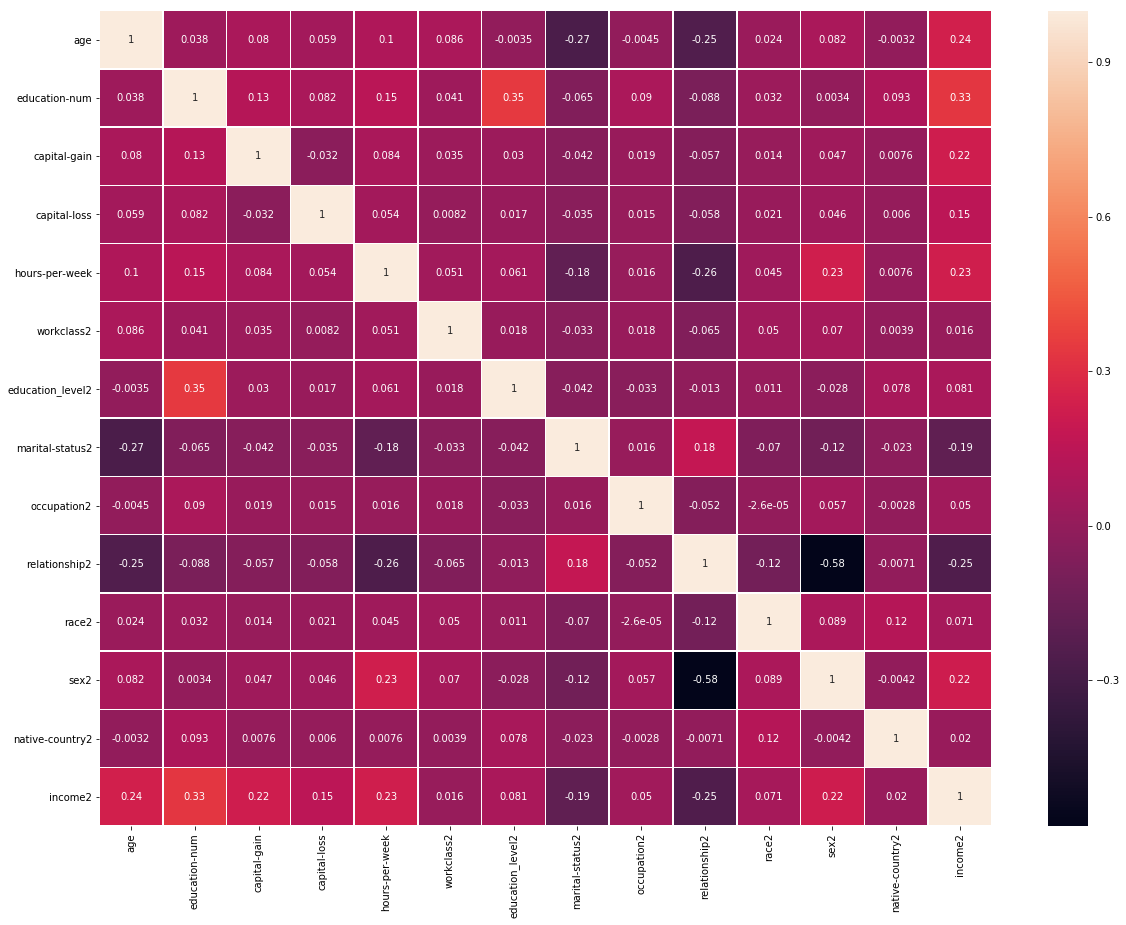

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
labelEncoder= LabelEncoder()
import seaborn as sns
# we will convert the categorial variables to numerical variables using label encoding so we can plot the heatmap
data['workclass2']=labelEncoder.fit_transform(data['workclass'])
data = data.drop('workclass', axis = 1)
data['education_level2']=labelEncoder.fit_transform(data['education_level'])
data = data.drop('education_level', axis = 1)
data['marital-status2']=labelEncoder.fit_transform(data['marital-status'])
data = data.drop('marital-status', axis = 1)
data['occupation2']=labelEncoder.fit_transform(data['occupation'])
data  = data.drop('occupation', axis = 1)
data['relationship2']=labelEncoder.fit_transform(data['relationship'])
data = data.drop('relationship', axis = 1)
data['race2']=labelEncoder.fit_transform(data['race'])
data = data.drop('race', axis = 1)
data['sex2']=labelEncoder.fit_transform(data['sex'])
data = data.drop('sex', axis = 1)
data['native-country2']=labelEncoder.fit_transform(data['native-country'])
data= data.drop('native-country', axis = 1)
data['income2']=labelEncoder.fit_transform(data['income'])
data= data.drop('income', axis = 1)
data.head(n=10)
plt.subplots(figsize=(20,15))

sns.heatmap(data.corr(), annot=True, linewidths=.5)
# https://www.mygreatlearning.com/blog/label-encoding-in-python/

 The lighter the color, the stronger the correlation. As we can see the correlation between each feature and the target are demonstrated in the last row. We can infer that the most important features for predicting the income are age, education-num, capital-gain, hour-per-week, and sex.

The order will be: 
- 1- education-num (corr:0.33)
- 2- age (corr:0.24)
- 3- hours-per-week (corr:0.23)
- 4- capital-gain (corr:0.22)
- 5- sex (corr:0.22)

The most correlated feature to the outcome (which is income) comes first in the feature importance order.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

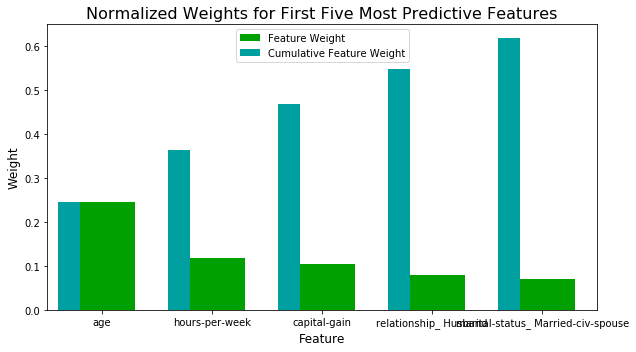

In [13]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = clf_C.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

**Question 7** - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above $50,000.
How do these five features compare to the five features you discussed in Question 6?

* 4 of them which are age, hours-per-week, capital-gain, education-num are the same as the features described in question 6 but martial status is not.

If you were close to the same answer, how does this visualization confirm your thoughts?

* The features I believed to be most important in question 6 are close to the features in the graph but there is a slight difference in the order of these features.

If you were not close, why do you think these features are more relevant?

* Only one feature was not described earlier which is martial-status.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8423
F-score on testing data: 0.6849

Final Model trained on reduced data
------
Accuracy on testing data: 0.7835
F-score on testing data: 0.5073


### Question 8 - Effects of Feature Selection

How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* **Reduced data** Accuracy is 0.8264, and F-score is 0.6479.
* **Full data** Accuracy is 0.8423, and F-score is 0.6849.
* The models's accuracy on full data is more than the model's accuracy on reduced data by 0.0159, and the models's F-score on full data is more than the model's F-score on reduced data by 0.037.

If training time was a factor, would you consider using the reduced data as your training set?
* As there is only a slight difference between the results of accuracy and F-score of the full and reduced data (as described above), it is a good pracitce to use the reduced data in order to reduce processing time.